## Классификация текстов

In [1]:
import os
import gc
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import torch

from torchtext.legacy.datasets import IMDB
from torchtext.legacy.data import Field, LabelField, BucketIterator, dataset

from torchtext.vocab import Vectors, GloVe
from sklearn.metrics import f1_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

Определим device:

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
if device == 'cuda':
    !nvidia-smi

Wed Apr 20 11:42:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Зафиксируем random:

In [4]:
SEED = 1234

def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)     
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

Будем использовать библиотеку torchtext:

In [5]:
TEXT = Field(sequential=True, lower=True, include_lengths=True)  # Поле текста
LABEL = LabelField(dtype=torch.float)                            # Поле метки

Датасет на котором мы будем проводить эксперементы это комментарии к фильмам из сайта IMDB.

In [6]:
train, test = IMDB.splits(TEXT, LABEL)                      # загрузим датасет
train, valid = train.split(random_state=random.seed(SEED))  # разобъём на части

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:08<00:00, 9.60MB/s]


In [7]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [8]:
train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test),
    batch_size=32,
    sort_within_batch=True,
    device=device)

## RNN

Используем рекурентные нейронные сети

In [9]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers, bidirectional, dropout, pad_idx):
        
        super().__init__()

        self.dropout = dropout
        self.embedding = nn.Embedding(vocab_size,
                                      embedding_dim, 
                                      padding_idx=pad_idx)
        
        self.rnn = nn.LSTM(input_size=embedding_dim,
                           hidden_size=hidden_dim,
                           num_layers=n_layers,
                           batch_first=False,
                           dropout=0,
                           bidirectional=bidirectional)
        
        self.fc = nn.Linear((1 + bidirectional) * hidden_dim, output_dim)
        
        
    def forward(self, text, text_lengths):
        """
        text: input texts, [sent len, batch size]
        text_length: tensor with lengths of input texts
        """

        embedded = self.embedding(text)  # [sent len, batch size, emb dim]
        
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            text_lengths)

        # cell arg for LSTM, remove for GRU
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
  
        # unpack sequence
        # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors

        # concat the final forward (hidden[-2,:,:]) and
        # backward (hidden[-1,:,:]) hidden layers
        if bidirectional:
            hidden = torch.cat([hidden[-2,:, :], hidden[-1,:,:]], dim=1)
        else:
            hidden = hidden[-1,:,:]    
        # hidden = [batch size, hid dim * num directions]

        # and apply dropout
        hidden = nn.Dropout(p=self.dropout)(hidden)

        fc_output = self.fc(hidden)
            
        return fc_output

In [10]:
vocab_size = len(TEXT.vocab)
emb_dim = 256
hidden_dim = 512
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
patience = 3

In [11]:
model_rnn = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX)

In [12]:
model_rnn.to(device)

RNNBaseline(
  (embedding): Embedding(201703, 256, padding_idx=1)
  (rnn): LSTM(256, 512, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=1, bias=True)
)

In [13]:
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()

max_epochs = 20

Обучим сеть:

In [14]:
def train_rnn(model, criterion, optimizer, max_epochs,
             train_loader, valid_loader, patience, max_grad_norm=2):
    history = []
    min_loss = np.inf
    cur_patience = 0
    for epoch in range(1, max_epochs + 1):
        train_loss = 0.0
        model.train()
        pbar = tqdm(enumerate(train_loader), 
                    total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")
        for it, batch in pbar:
            optimizer.zero_grad()
            input_embeds = batch.text[0].to(device)
            embeds_lengths = batch.text[1].to('cpu')
            labels = batch.label.to(device).unsqueeze(1)
            prediction = model(input_embeds, embeds_lengths)
            loss = criterion(prediction, labels)
            train_loss += loss
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                               max_grad_norm)
            optimizer.step()
        train_loss /= len(train_loader)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            pbar = tqdm(enumerate(valid_loader), 
                        total=len(valid_loader), leave=True)
            pbar.set_description(f"Epoch {epoch}")
            for it, batch in pbar:
                input_embeds = batch.text[0].to(device)
                embeds_lengths = batch.text[1].to('cpu')
                labels = batch.label.to(device).unsqueeze(1)
                prediction = model(input_embeds, embeds_lengths)
                loss = criterion(prediction, labels)
                val_loss += loss
            val_loss /= len(valid_loader)

        history.append((train_loss.detach().cpu(), val_loss.detach().cpu()))

        if val_loss < min_loss:
            min_loss = val_loss
            best_model = model.state_dict()
        else:
            cur_patience += 1
            if cur_patience == patience:
                break

        # clear cache
        gc.collect()
        torch.cuda.empty_cache()
    
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
    model.load_state_dict(best_model)
    return history

In [ ]:
history_rnn = train_rnn(model_rnn, criterion, optimizer, 
                        max_epochs, train_iter, valid_iter, patience)

  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.662562370300293, Validation Loss: 0.6331970691680908


  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.532272219657898, Validation Loss: 0.47783318161964417


  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.37549909949302673, Validation Loss: 0.35671666264533997


  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.2541079819202423, Validation Loss: 0.33956149220466614


  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.17666049301624298, Validation Loss: 0.450121134519577


  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.1295495182275772, Validation Loss: 0.36223697662353516


  0%|          | 0/547 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
loss_rnn, val_loss_rnn  = zip(*history_rnn)

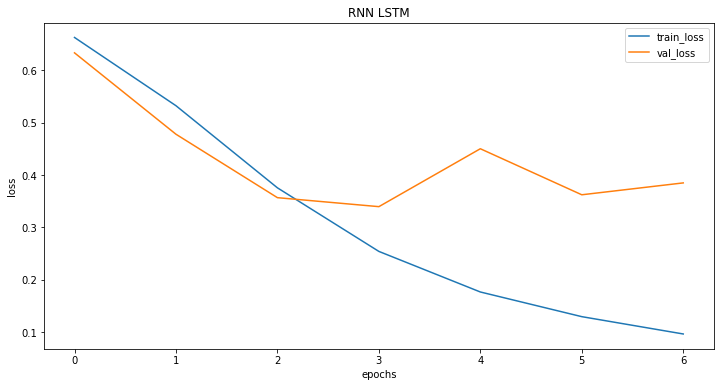

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(loss_rnn, label="train_loss")
plt.plot(val_loss_rnn, label="val_loss")
plt.legend(loc='best')
plt.title("RNN LSTM")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [15]:
def predict_rnn(model, criterion, test_loader):
    model.eval()
    with torch.no_grad():
        lb = torch.tensor([])
        pr = torch.tensor([])
        test_loss = 0.0
        pbar = tqdm(enumerate(test_loader), total=len(test_loader), leave=True)
        for it, batch in pbar:
            input_embeds = batch.text[0].to(device)
            embeds_lengths = batch.text[1].to('cpu')
            labels = batch.label.to(device).unsqueeze(1)
            preds = model(input_embeds, embeds_lengths)
            prediction = torch.sigmoid(preds)
            loss = criterion(prediction, labels)
            test_loss += loss
            lb = torch.cat((lb, labels.cpu()))
            pr = torch.cat((pr, prediction.cpu()))
        test_loss /= len(test_loader)
        test_f1 = f1_score(lb.numpy(), pr.numpy() > 0.5, average='weighted')
        print('Loss: {}, F1 Score: {}'.format(test_loss, test_f1))

f1-score:

In [ ]:
predict_rnn(model_rnn, criterion, test_iter)

  0%|          | 0/782 [00:00<?, ?it/s]

Loss: 0.5734073519706726, F1 Score: 0.8705077657808986


## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очень хороший фильм" или "невероятная скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно.

In [16]:
# batch_first т.к. используем conv
TEXT = Field(sequential=True, lower=True, batch_first=True)  
LABEL = LabelField(batch_first=True, dtype=torch.float)

trn, tst = IMDB.splits(TEXT, LABEL)
trn, vld = trn.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

In [17]:
trn_iter, vld_iter, tst_iter = BucketIterator.splits(
    (trn, vld, tst),
    batch_sizes=(128, 256, 256),
    sort=False,
    sort_key=lambda x: len(x.src),
    sort_within_batch=False,
    device=device,
    repeat=False)

In [18]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, 
                 out_channels, kernel_sizes, dropout=0.5):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        
        self.conv_0 = nn.Conv1d(in_channels=emb_dim, 
                                out_channels=out_channels, 
                                kernel_size=kernel_sizes[0], 
                                padding=1, stride=2)
        
        self.conv_1 = nn.Conv1d(in_channels=emb_dim, 
                                out_channels=out_channels, 
                                kernel_size=kernel_sizes[1], 
                                padding=1, stride=2)
        
        self.conv_2 = nn.Conv1d(in_channels=emb_dim, 
                                out_channels=out_channels, 
                                kernel_size=kernel_sizes[2], 
                                padding=1, stride=2)
        
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)       # [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)  # [batch size, emb dim, sent len]
        
        conved_0 = F.relu(self.conv_0(embedded))  
        conved_1 = F.relu(self.conv_1(embedded))  
        conved_2 = F.relu(self.conv_2(embedded))  
        
        # [batch size, out ch]
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2) 
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2) 
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2) 

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        output = self.fc(cat)
            
        return output

In [19]:
kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
out_channels = 128
dropout = 0.5
dim = 300
patience = 3

In [20]:
model_cnn = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
                kernel_sizes=kernel_sizes, dropout=dropout)

In [21]:
model_cnn.to(device)

CNN(
  (embedding): Embedding(201703, 300)
  (conv_0): Conv1d(300, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv_1): Conv1d(300, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (conv_2): Conv1d(300, 128, kernel_size=(5,), stride=(2,), padding=(1,))
  (fc): Linear(in_features=384, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [22]:
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()

max_epochs = 20

In [23]:
def train_cnn(model, criterion, optimizer, max_epochs,
             train_loader, valid_loader, patience, max_grad_norm=2):
    history = []
    min_loss = np.inf
    cur_patience = 0
    for epoch in range(1, max_epochs + 1):
        train_loss = 0.0
        model.train()
        pbar = tqdm(enumerate(train_loader), 
                    total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")
        for it, batch in pbar:
            optimizer.zero_grad()
            input_embeds = batch.text.to(device)
            labels = batch.label.to(device).unsqueeze(1)
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                               max_grad_norm)
            optimizer.step()
        train_loss /= len(train_loader)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            pbar = tqdm(enumerate(valid_loader), 
                        total=len(valid_loader), leave=True)
            pbar.set_description(f"Epoch {epoch}")
            for it, batch in pbar:
                input_embeds = batch.text.to(device)
                labels = batch.label.to(device).unsqueeze(1)
                prediction = model(input_embeds)
                loss = criterion(prediction, labels)
                val_loss += loss
            val_loss /= len(valid_loader)

        history.append((train_loss.detach().cpu(), val_loss.detach().cpu()))

        if val_loss < min_loss:
            min_loss = val_loss
            best_model = model.state_dict()
        else:
            cur_patience += 1
            if cur_patience == patience:
                break

        # clear cache
        gc.collect()
        torch.cuda.empty_cache()
    
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
    model.load_state_dict(best_model)
    return history

In [24]:
history_cnn = train_cnn(model_cnn, criterion, optimizer, 
                        max_epochs, trn_iter, vld_iter, patience)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.6549403071403503, Validation Loss: 0.5205458402633667


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.5027747750282288, Validation Loss: 0.45484495162963867


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.41788429021835327, Validation Loss: 0.4037601351737976


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.34490200877189636, Validation Loss: 0.3672335147857666


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.2786477208137512, Validation Loss: 0.34875550866127014


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.20622704923152924, Validation Loss: 0.34566545486450195


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.1558218002319336, Validation Loss: 0.34089264273643494


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.0951736643910408, Validation Loss: 0.36643221974372864


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.06646093726158142, Validation Loss: 0.38232237100601196


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
loss_cnn, val_loss_cnn  = zip(*history_cnn)

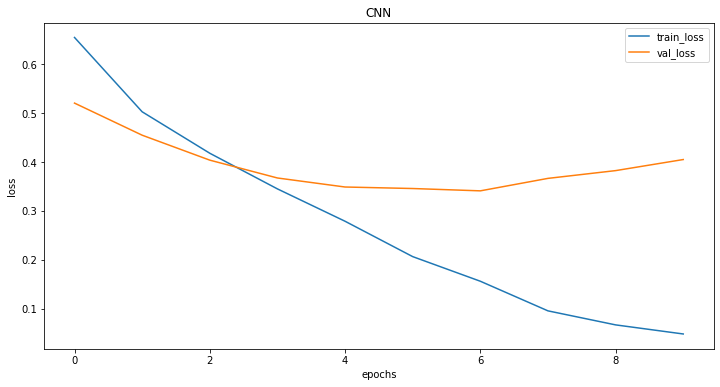

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(loss_cnn, label="train_loss")
plt.plot(val_loss_cnn, label="val_loss")
plt.legend(loc='best')
plt.title("CNN")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [27]:
def predict_cnn(model, criterion, test_loader):
    model.eval()
    with torch.no_grad():
        lb = torch.tensor([])
        pr = torch.tensor([])
        test_loss = 0.0
        pbar = tqdm(enumerate(test_loader), total=len(test_loader), leave=True)
        for it, batch in pbar:
            input_embeds = batch.text.to(device)
            labels = batch.label.to(device).unsqueeze(1)
            preds = model(input_embeds)
            prediction = torch.sigmoid(preds)
            loss = criterion(prediction, labels)
            test_loss += loss
            lb = torch.cat((lb, labels.cpu()))
            pr = torch.cat((pr, prediction.cpu()))
        test_loss /= len(test_loader)
        test_f1 = f1_score(lb.numpy(), pr.numpy() > 0.5, average='weighted')
        print('Loss: {}, F1 Score: {}'.format(test_loss, test_f1))

f1-score:

In [28]:
predict_cnn(model_cnn, criterion, tst_iter)

  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5756725072860718, F1 Score: 0.8618790663024882


## Интерпретируемость

Посмотрим, куда смотрит наша модель

In [29]:
!pip install -q captum

     |████████████████████████████████| 1.4 MB 33.9 MB/s 


In [30]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

In [31]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model_cnn, model_cnn.embedding)

In [32]:
def forward_with_softmax(inp, model):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input, model):
    return torch.sigmoid(model(input))


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len=7, label=0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices, model).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, 
                                                           device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, 
                                           reference_indices, 
                                           n_steps=5000, 
                                           return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, 
                                   label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, 
                                   pred_ind, label, delta, vis_data_records):
    
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [ ]:
interpret_sentence(model_cnn, 'It was a fantastic performance !', label=1)
interpret_sentence(model_cnn, 'Best film ever', label=1)
interpret_sentence(model_cnn, 'Such a great show!', label=1)
interpret_sentence(model_cnn, 'It was a horrible movie', label=0)
interpret_sentence(model_cnn, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model_cnn, 'It is a disgusting movie!', label=0)

pred:  pos ( 1.00 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.59 ) , delta:  tensor([1.1259e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.98 ) , delta:  tensor([4.3867e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.08 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.18 ) , delta:  tensor([2.2231e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.01 ) , delta:  tensor([4.2674e-05], device='cuda:0', dtype=torch.float64)


Попробуйте добавить свои примеры!

In [ ]:
interpret_sentence(model_cnn, 'It was a spectacular performance !', label=1)
interpret_sentence(model_cnn, 'Great show ever', label=1)
interpret_sentence(model_cnn, 'Such a wonderful show!', label=1)
interpret_sentence(model_cnn, 'It was a boring movie', label=0)
interpret_sentence(model_cnn, 'I\'ve never watched something as dumb', label=0)
interpret_sentence(model_cnn, 'It is a stupid movie!', label=0)

pred:  pos ( 0.95 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.64 ) , delta:  tensor([2.1028e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.99 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.40 ) , delta:  tensor([2.1788e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([3.3848e-05], device='cuda:0', dtype=torch.float64)


In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (1.00),pos,1.60,It was a fantastic performance ! pad
pos,pos (0.59),pos,1.63,Best film ever pad pad pad pad
pos,pos (0.98),pos,1.34,Such a great show! pad pad pad
neg,neg (0.08),pos,-0.71,It was a horrible movie pad pad
neg,neg (0.18),pos,-0.38,I've never watched something as bad pad
neg,neg (0.01),pos,-0.95,It is a disgusting movie! pad pad
pos,pos (0.95),pos,1.57,It was a spectacular performance ! pad
pos,pos (0.64),pos,1.49,Great show ever pad pad pad pad
pos,pos (0.99),pos,1.36,Such a wonderful show! pad pad pad
neg,neg (0.00),pos,-0.87,It was a boring movie pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (1.00),pos,1.60,It was a fantastic performance ! pad
pos,pos (0.59),pos,1.63,Best film ever pad pad pad pad
pos,pos (0.98),pos,1.34,Such a great show! pad pad pad
neg,neg (0.08),pos,-0.71,It was a horrible movie pad pad
neg,neg (0.18),pos,-0.38,I've never watched something as bad pad
neg,neg (0.01),pos,-0.95,It is a disgusting movie! pad pad
pos,pos (0.95),pos,1.57,It was a spectacular performance ! pad
pos,pos (0.64),pos,1.49,Great show ever pad pad pad pad
pos,pos (0.99),pos,1.36,Such a wonderful show! pad pad pad
neg,neg (0.00),pos,-0.87,It was a boring movie pad pad


Все предложения классиффицированы правильно!

## Эмбеддинги слов

Используем эмбеддинги для повышения качества модели

In [ ]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  
LABEL = LabelField(batch_first=True, dtype=torch.float)

In [ ]:
train, tst = IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

In [ ]:
TEXT.build_vocab(trn, vectors=GloVe())

LABEL.build_vocab(trn)

word_embeddings = TEXT.vocab.vectors

kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300
patience = 3

.vector_cache/glove.840B.300d.zip: 2.18GB [06:51, 5.29MB/s]                            
100%|█████████▉| 2196016/2196017 [05:26<00:00, 6732.16it/s]


In [ ]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key=lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False)

In [ ]:
model_cnn_emb = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=128,
                    kernel_sizes=kernel_sizes, dropout=dropout)

In [ ]:
word_embeddings = TEXT.vocab.vectors

prev_shape = model_cnn_emb.embedding.weight.shape

In [ ]:
with torch.no_grad():
    for i in range(len(word_embeddings)):
        model_cnn_emb.embedding.weight[i] = word_embeddings[i]

assert prev_shape == model_cnn_emb.embedding.weight.shape

In [ ]:
model_cnn_emb.to(device)

CNN(
  (embedding): Embedding(202718, 300)
  (conv_0): Conv1d(300, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv_1): Conv1d(300, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (conv_2): Conv1d(300, 128, kernel_size=(5,), stride=(2,), padding=(1,))
  (fc): Linear(in_features=384, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
optimizer = torch.optim.Adam(model_cnn_emb.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()

max_epochs = 20

In [ ]:
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embedding
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

In [ ]:
def train_cnn_emb(model, criterion, optimizer, max_epochs, train_loader, 
                  valid_loader, patience, max_grad_norm=2, num_freeze_iter=1000):
    history = []
    min_loss = np.inf
    cur_patience = 0
    for epoch in range(1, max_epochs + 1):
        train_loss = 0.0
        model.train()
        pbar = tqdm(enumerate(train_loader), 
                    total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")
        for it, batch in pbar:
            if it > num_freeze_iter and epoch < 2:
                freeze_embeddings(model, True)
            optimizer.zero_grad()
            input_embeds = batch.text.to(device)
            labels = batch.label.to(device).unsqueeze(1)
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 
                                               max_grad_norm)
            optimizer.step()
        train_loss /= len(train_loader)

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            pbar = tqdm(enumerate(valid_loader), 
                        total=len(valid_loader), leave=True)
            pbar.set_description(f"Epoch {epoch}")
            for it, batch in pbar:
                input_embeds = batch.text.to(device)
                labels = batch.label.to(device).unsqueeze(1)
                prediction = model(input_embeds)
                loss = criterion(prediction, labels)
                val_loss += loss
            val_loss /= len(valid_loader)

        history.append((train_loss.detach().cpu(), val_loss.detach().cpu()))

        if val_loss < min_loss:
            min_loss = val_loss
            best_model = model.state_dict()
        else:
            cur_patience += 1
            if cur_patience == patience:
                break

        # clear cache
        gc.collect()
        torch.cuda.empty_cache()
    
        print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
    model.load_state_dict(best_model)
    return history

In [ ]:
history_cnn_emb = train_cnn_emb(model_cnn_emb, criterion, optimizer, 
                                max_epochs, train_iter, val_iter, patience)

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 0.47040441632270813, Validation Loss: 0.3326015770435333


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.2701634466648102, Validation Loss: 0.29657989740371704


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.15007156133651733, Validation Loss: 0.2855628430843353


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.060149896889925, Validation Loss: 0.32969632744789124


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.021368565037846565, Validation Loss: 0.347140371799469


  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
loss_cnn_emb, val_loss_cnn_emb  = zip(*history_cnn_emb)

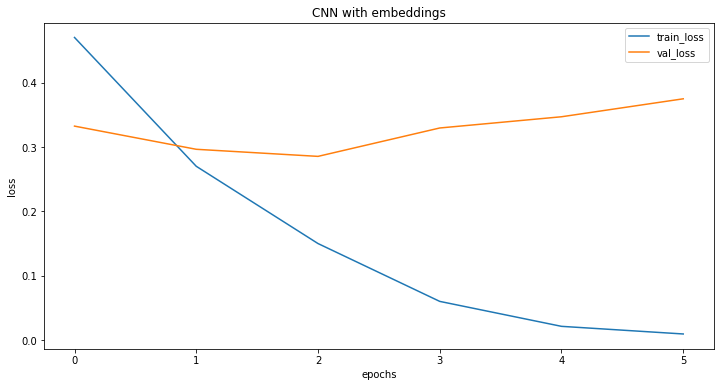

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(loss_cnn_emb, label="train_loss")
plt.plot(val_loss_cnn_emb, label="val_loss")
plt.legend(loc='best')
plt.title("CNN with embeddings")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

f1-score:

In [ ]:
predict_cnn(model_cnn_emb, criterion, test_iter)

  0%|          | 0/98 [00:00<?, ?it/s]

Loss: 0.5694278478622437, F1 Score: 0.8765745484870137


Проверим насколько все хорошо:

In [ ]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model_cnn_emb, model_cnn_emb.embedding)
vis_data_records_ig = []

In [ ]:
interpret_sentence(model_cnn_emb, 'It was a fantastic performance !', label=1)
interpret_sentence(model_cnn_emb, 'Best film ever', label=1)
interpret_sentence(model_cnn_emb, 'Such a great show!', label=1)
interpret_sentence(model_cnn_emb, 'It was a horrible movie', label=0)
interpret_sentence(model_cnn_emb, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model_cnn_emb, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.99 ) , delta:  tensor([8.9726e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.01 ) , delta:  tensor([3.1519e-05], device='cuda:0', dtype=torch.float64)
pred:  pos ( 0.70 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([6.8793e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.24 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([7.3149e-05], device='cuda:0', dtype=torch.float64)


In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.99),pos,1.77,It was a fantastic performance ! pad
pos,neg (0.01),pos,0.94,Best film ever pad pad pad pad
pos,pos (0.70),pos,1.57,Such a great show! pad pad pad
neg,neg (0.00),pos,-0.51,It was a horrible movie pad pad
neg,neg (0.24),pos,1.25,I've never watched something as bad pad
neg,neg (0.00),pos,-0.77,It is a disgusting movie! pad pad


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.99),pos,1.77,It was a fantastic performance ! pad
pos,neg (0.01),pos,0.94,Best film ever pad pad pad pad
pos,pos (0.70),pos,1.57,Such a great show! pad pad pad
neg,neg (0.00),pos,-0.51,It was a horrible movie pad pad
neg,neg (0.24),pos,1.25,I've never watched something as bad pad
neg,neg (0.00),pos,-0.77,It is a disgusting movie! pad pad


F1 score модели CNN+Embedding выше чем модели CNN, но на этапе тестирования на примерах модель CNN+Embedding допускает одну ошибку.